In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from scipy.stats.distributions import norm
from scipy.optimize import fmin, minimize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
# from pydataset import data as pydata
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

# ARIMA 
### Uploading Data
Here we upload the `salesdaily.csv` in an attempt to forecast future drug purchase quantities.

In [ ]:
# getting dataset
df = pd.read_csv('salesdaily.csv.xls')

# changing to datatime object
df['datum']= pd.to_datetime(df['datum'])

# getting preview of our dataset
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,2014-01-02,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,2014-01-03,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,2014-01-04,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,2014-01-05,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,2014-01-06,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [ ]:
display(df)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-05,14.00,11.670,21.30,185.950,41.0,0.0,32.000000,7.00
1,2014-01-12,29.33,12.680,37.90,190.700,88.0,5.0,21.000000,7.20
2,2014-01-19,30.67,26.340,45.90,218.400,80.0,8.0,29.000000,12.00
3,2014-01-26,34.00,32.370,31.50,179.600,80.0,8.0,23.000000,10.00
4,2014-02-02,31.02,23.350,20.70,159.880,84.0,12.0,29.000000,12.00
...,...,...,...,...,...,...,...,...,...
297,2019-09-15,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
298,2019-09-22,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
299,2019-09-29,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
300,2019-10-06,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13


In [ ]:
# creating training, validation, and test datasets
train, valid = train_test_split(df, test_size=.1, shuffle=False)
valid, test = train_test_split(valid, test_size=.4, shuffle=False)

## Naivë ARMA

### Examining Data for Naivë ARMA
Here we examine whether or not the data is a good canidate for ARMA. We also use the following to determine the parameters p and q if we are using the naivë approach.

In [ ]:
def code_subplots(data, plt_title, difference=True):
  """ 
  Creates a graph showing the relationships between various z_t's.

  Parameters:
    zt: original data (train)
    plt_title: drug name to be used for plot title (str)
    difference: true is want to calculate difference, false if
                wants to use original data (bool)

  Used to visualize differences in z_t's as means to naively estimate
  parameter p for ARMA.

  """
  # if we want the difference
  if difference:
    zt = np.diff(data)
    plt_title += '$: z_{t} = Difference$'
  
  # if we want to use the data
  else:
    zt = data
    plt_title += '$: z_{t} = Data$'

  # getting slope/intercepts for LSRL for zt
  m1, b1 = np.polyfit(zt[1:], zt[:-1], 1)
  m2, b2 = np.polyfit(zt[2:], zt[:-2], 1)
  m3, b3 = np.polyfit(zt[3:], zt[:-3], 1)

  # setting up subplot
  fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

  # plotting scatterplots with LSRL
  ax[0].scatter(zt[1:], zt[:-1], alpha=.2)
  ax[0].plot(zt[1:], m1*zt[1:]+b1, 'r')
  ax[1].scatter(zt[2:], zt[:-2], alpha=.2)
  ax[1].plot(zt[2:], m2*zt[2:]+b2, 'r')
  ax[2].scatter(zt[3:], zt[:-3], alpha=.2)
  ax[2].plot(zt[3:], m3*zt[3:]+b3, 'r')

  # setting labels to make more clear to reader
  ax[0].set_xlabel('$z_{t}$')
  ax[0].set_ylabel('$z_{t-1}$')
  ax[1].set_xlabel('$z_{t}$')
  ax[1].set_ylabel('$z_{t-2}$')
  ax[2].set_xlabel('$z_{t}$')
  ax[2].set_ylabel('$z_{t-3}$')
  fig.suptitle(plt_title)

  # displaying graph
  plt.show()

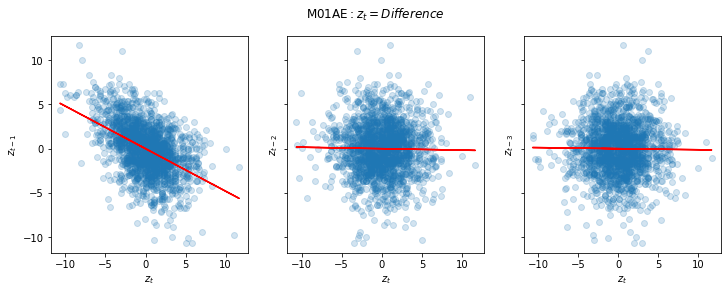

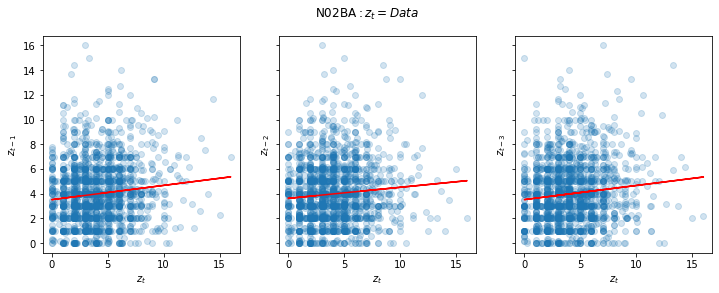

In [ ]:
# for reference we have included two examples of these plots
code_subplots(train['M01AE'], 'M01AE', difference=True)
code_subplots(train['N02BA'], 'N02BA', difference=False)

Upon analyzing various plots, we decided upon the following for each drug for our naivë method.
* M01AB: differences, p=1
* M01AE: differences, p=1
* N02BA: data, p=3
* N02BE: data, p=3
* N05B: data, p=3 (most emphasis on 2)
* N05C: differences, p=1
* R03: differences, p=1
* R06: data, p=3 (potentially more)

While there are plenty of options to explore here, we consider taking a deeper look at the N02BA drug as it appears most appropriate for this technique. (We recognize this still may not be the most appropriate technique, however for the sake of understand ARMA we move forward with the caveat we may not end up using this model). 

For the MA portion of the model, we use q=1 (again with the naivë method of educated guess).



### Hyperparameter Tuning on Validation Dataset

In [ ]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
                              np.eye(dim_states**2).dot(Q.flatten())).reshape(
                            (dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        #FIXME
        t1 = np.linalg.solve(H.dot(covs[i-1]).dot(H.T),np.eye(H.shape[0]))
        t2 = covs[i-1].dot(H.T.dot(t1.dot(H.dot(covs[i-1]))))
        covs[i] = F.dot((covs[i-1] - t2).dot(F.T)) + Q
        mus[i] = F.dot(mus[i-1]) + F.dot(covs[i-1].dot(H.T.dot(t1))).dot(
                time_series[i-1] - H.dot(mus[i-1]))
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0][:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

In [ ]:
def arma_likelihood(ts, phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # Load time series
    time_series = ts
    time_series = np.diff(a=time_series, n=1)

    # Get F, Q, and H
    F, Q, H, _, _ = state_space_rep(phis, thetas, mu, std)

    # Call Kalman
    mus, covs = kalman(F, Q, H, time_series-mu)

    # Compute log liklihood
    log_liklihood = np.sum([np.log(norm(H@mus[t] + mu, np.sqrt(H@covs[t]@H.T)).pdf(time_series[t])) for t in range(len(mus))])
    return log_liklihood
    
# arma_likelihood(train['N02BA'], phis=np.array([0.9]),thetas=np.array([0]), mu=17., std=0.4)

In [ ]:
def model_identification(ts,p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    # Load time series
    time_series = ts
    # time_series = np.diff(a=time_series, n=1)
    n = len(time_series)
    
    # Make aicc function and initialize best params
    aic_func = lambda k, n, l: 2*k*(1 + (k+1)/(n-k)) + 2*l
    best_params, best_p, best_q, best_aic = 0, 0, 0, np.inf
    
    # Perform the grid search
    for p in range(1, p_max+1):
        print(p)
        for q in range(1, q_max+1):
            print(f"   {q}")
            x0 = np.zeros(p+q+2)+10e-6
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            
            def f(x): # x contains the phis, thetas, mu, and sigma
                return -1*arma_likelihood(ts, phis=x[:p], thetas=x[p:p+q],mu=x[-2], std=x[-1])

            # Minimize
            sol = minimize(f,  x0, method = "SLSQP").x

            # Compute curr aic
            curr_aic = aic_func(p+q+2, n, f(sol))

            if curr_aic < best_aic:
                # Update the best params
                best_params, best_p, best_q = sol, p, q, 
                best_aic = curr_aic
    return best_params[:best_p], best_params[best_p:best_p+best_q], best_params[-2], best_params[-1]

model_identification(train, p_max=3, q_max=3)

1
   1


<ipython-input-8-c7ad027e6f22>:27: RuntimeWarning: invalid value encountered in sqrt
  log_liklihood = np.sum([np.log(norm(H@mus[t] + mu, np.sqrt(H@covs[t]@H.T)).pdf(time_series[t])) for t in range(len(mus))])
<ipython-input-8-c7ad027e6f22>:27: RuntimeWarning: divide by zero encountered in log
  log_liklihood = np.sum([np.log(norm(H@mus[t] + mu, np.sqrt(H@covs[t]@H.T)).pdf(time_series[t])) for t in range(len(mus))])


   2
   3


<ipython-input-7-eee6a30d4de5>:22: RuntimeWarning: invalid value encountered in add
  mus[i] = F.dot(mus[i-1]) + F.dot(covs[i-1].dot(H.T.dot(t1))).dot(
/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:292: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
<ipython-input-8-c7ad027e6f22>:27: RuntimeWarning: overflow encountered in matmul
  log_liklihood = np.sum([np.log(norm(H@mus[t] + mu, np.sqrt(H@covs[t]@H.T)).pdf(time_series[t])) for t in range(len(mus))])


KeyboardInterrupt: ignored

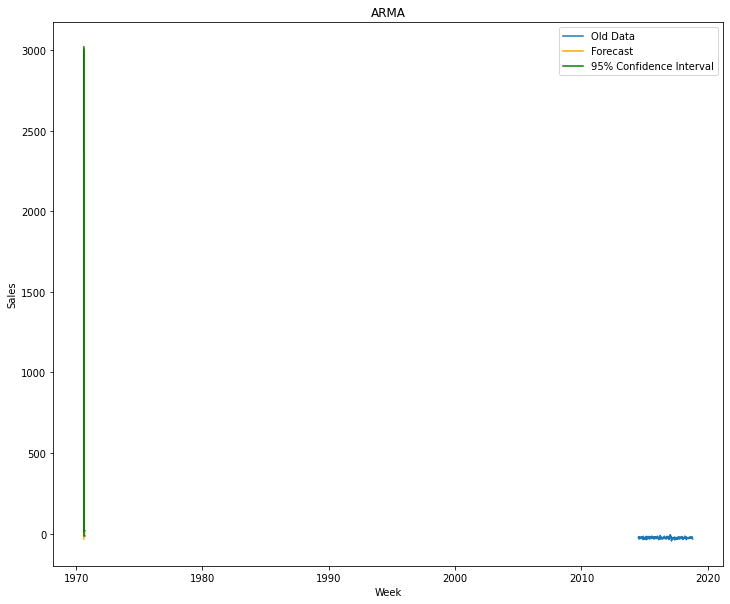

In [ ]:
def arma_forecast(ts, phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load time series
    data = ts
    # data = np.diff(a=time_series, n=1)

    # Get F, Q, and H
    F, Q, H, _, _ = state_space_rep(phis, thetas, mu, std)

    # Call Kalman
    mus, covs = kalman(F, Q, H, data-mu)

    # Execute update algorithm
    ytild = data[-1] - H@mus[-1]
    sk = H@covs[-1]@H.T
    kk = covs[-1]@H.T@np.linalg.inv(sk)
    xhat = mus[-1] + kk@ytild
    pk = (np.eye(kk.shape[0]) - kk@H)@covs[-1]

    # Transform back to obs space
    updated_mus, updated_covs = np.zeros(n+1), np.zeros(n+1)
    updated_mus[0], updated_covs[0] = H@mus[-1] + mu, H@covs[-1]@H.T

    xhats, pks = [xhat], [pk]
    for t in range(n):
        # Execute predict algorithm
        xhats.append(F@xhats[t] + mu)
        pks.append(F@pks[t]@F.T + Q)

        # Transform back to obs space
        updated_mus[t+1] = H@xhats[t] + mu
        updated_covs[t+1] = H@pks[t]@H.T

    # Plot
    plt.figure(figsize=(12,10))
    plt.plot(data, label='Old Data')
    plt.plot([val for val in range(len(data)-1, (len(data)-1)+n)], updated_mus[1:], c='orange', label='Forecast')
    plt.plot([val for val in range(len(data)-1, (len(data)-2)+n)], updated_mus[2:] + 2*np.sqrt(updated_covs[2:]), 'g', label='95% Confidence Interval')
    plt.plot([val for val in range(len(data)-1, (len(data)-2)+n)], updated_mus[2:] - 2*np.sqrt(updated_covs[2:]), 'g')
    plt.xlabel('Day')
    plt.ylabel('Sales')
    plt.title('ARMA')
    plt.legend()
    plt.show()
    
phis, thetas, mu, std = np.array([0.011813]),np.array([-0.99999592]),-0.0036021632926225905,5.431017509137173
arma_forecast(train, phis=phis, thetas=thetas, mu=mu, std=std, n=30)


# Talia's Code

In [ ]:
def arma_forecast_naive(data, I, O, E, c, n):
    """
    Perform ARMA(2,1) on data. Let error terms be drawn from
    a standard normal and let all constants be 1.
    Predict n values and plot original data with predictions.

    Parameters:
        data (ndarray): values of data from singular column (n, )
        I (ndarray): AR correlations (p, )
        O (ndarray): MA correlations (q, )
        E (ndarray): overall error of our estimates (n, )
        c (float): y-intercept baseline
        n (int): number of future predictions
    """
    # getting desired lengths
    p, q = len(I), len(O)

    # making the dataset covariance stationary
    zt = np.diff(data)

    # appending the data points
    zt = np.append(zt, np.zeros(n))

    # getting original length of data
    T = len(zt)-n

    for t in range(0, n):
        # getting the autoregressive model of order p
        ar = sum([I[i]*zt[T+t-i] for i in range(p)])

        # getting the moving averages of order q
        ma = sum([O[j]*E[T+t-j] for j in range(q)])
        
        # using equation 1.1
        zt[T+t] = c + ar + ma + E[T+t]
    
    return zt[T:]

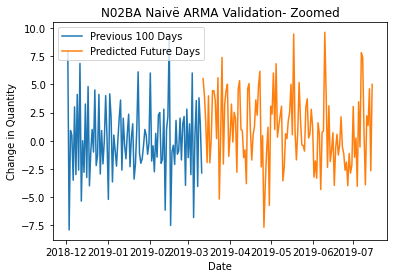

In [ ]:
# getting parameters with naivë guessing
I = np.ones(3) * .2
O = np.ones(1) * .4
n = len(valid['N02BA'])

# getting standard deviation based on history std
v = np.std(train['N02BA'][-101:])
E = np.random.normal(0, v, size=(n+len(train['N02BA'])))

# data is centered at approximately 0
c = 0

# getting zt from naivë method
zt = arma_forecast_naive(train['N02BA'], I, O, E, c, n)

# plotting the previous 100 days (note only for reference, all data passed into model)
plt.plot(train['datum'][-100:], np.diff(train['N02BA'][-101:]), label='Previous 100 Days')

# plotting out models predictions for the next 126 days
plt.plot(valid['datum'], zt, label='Predicted Future Days')

# plotting zoomed version
plt.title('N02BA Naivë ARMA Validation- Zoomed')
plt.xlabel('Date')
plt.ylabel('Change in Quantity')
plt.legend()
plt.show()

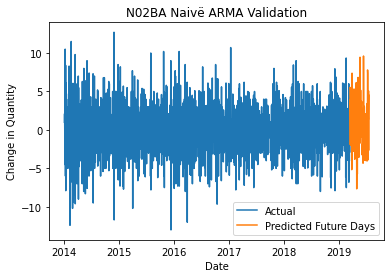

In [ ]:
# plotting all data
plt.plot(train['datum'][1:], np.diff(train['N02BA']), label='Actual')

# plotting out models predictions for the next 126 days
plt.plot(valid['datum'], zt, label='Predicted Future Days')

# plotting unzoomed version
plt.title('N02BA Naivë ARMA Validation')
plt.xlabel('Date')
plt.ylabel('Change in Quantity')
plt.legend()
plt.show()

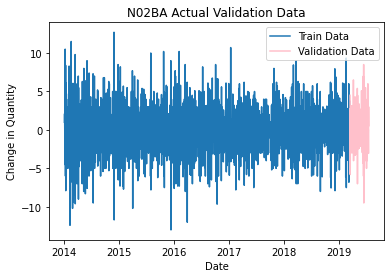

In [ ]:
# plotting all training data
plt.plot(train['datum'][1:], np.diff(train['N02BA']), label='Train Data')

# plotting all validation data
plt.plot(valid['datum'][1:], np.diff(valid['N02BA']), color='pink', label='Validation Data')

# plotting details
plt.title('N02BA Actual Validation Data')
plt.xlabel('Date')
plt.ylabel('Change in Quantity')
plt.legend()
plt.show()

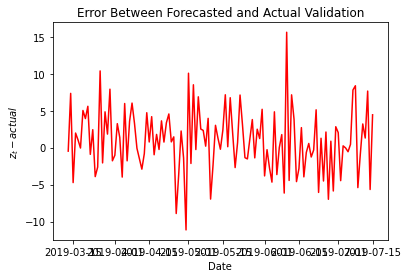

In [ ]:
plt.plot(valid['datum'][1:], zt[1:] - np.diff(valid['N02BA']), color='red', label='Validation Data')
plt.title('Error Between Forecasted and Actual Validation')
plt.xlabel('Date')
plt.ylabel('$z_{t} - actual$')
plt.show()

### Examining Results on Test Data

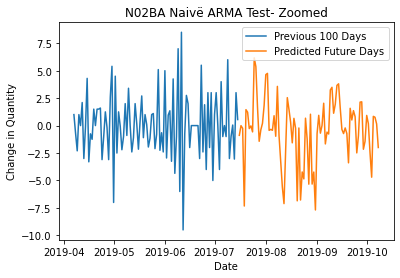

In [ ]:
# appending validation and training sets to use to predict test dataset
train_valid = train.append(valid)

# using parameters found in validation parameter tuning
I = np.ones(3) * .2
O = np.ones(1) * .4
n = len(test['N02BA'])

# getting standard deviation based on history std
v = np.std(train_valid['N02BA'][-101:])
E = np.random.normal(0, v, size=(n+len(train_valid['N02BA'])))

# data is centered at approximately 0
c = 0

# getting zt from naivë method
zt = arma_forecast_naive(train_valid['N02BA'], I, O, E, c, n)

# plotting the previous 100 days (note only for reference, all data passed into model)
plt.plot(train_valid['datum'][-100:], np.diff(train_valid['N02BA'][-101:]), label='Previous 100 Days')

# plotting out models predictions for the next 126 days
plt.plot(test['datum'], zt, label='Predicted Future Days')

# plotting zoomed version
plt.title('N02BA Naivë ARMA Test- Zoomed')
plt.xlabel('Date')
plt.ylabel('Change in Quantity')
plt.legend()
plt.show()

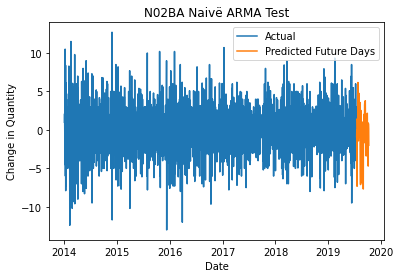

In [ ]:
# plotting all data
plt.plot(train_valid['datum'][1:], np.diff(train_valid['N02BA']), label='Actual')

# plotting out models predictions for the next 126 days
plt.plot(test['datum'], zt, label='Predicted Future Days')

# plotting unzoomed version
plt.title('N02BA Naivë ARMA Test')
plt.xlabel('Date')
plt.ylabel('Change in Quantity')
plt.legend()
plt.show()

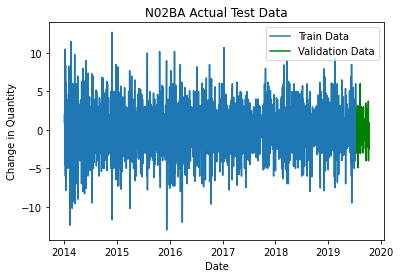

In [ ]:
# plotting all training data
plt.plot(train_valid['datum'][1:], np.diff(train_valid['N02BA']), label='Train Data')

# plotting all test data
plt.plot(test['datum'][1:], np.diff(test['N02BA']), color='green', label='Validation Data')

# plotting details
plt.title('N02BA Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Change in Quantity')
plt.legend()
plt.show()

## ADD MORE STUFF LATER!

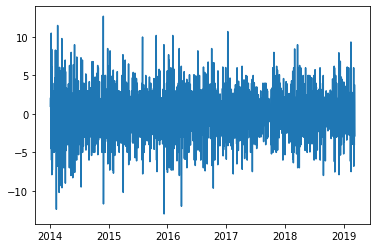

In [ ]:
plt.plot(train['datum'][1:], np.diff(train['N02BA']))

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
drive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<module 'google.colab.drive' from '/usr/local/lib/python3.9/dist-packages/google/colab/drive.py'>

## Look for seasonal trends

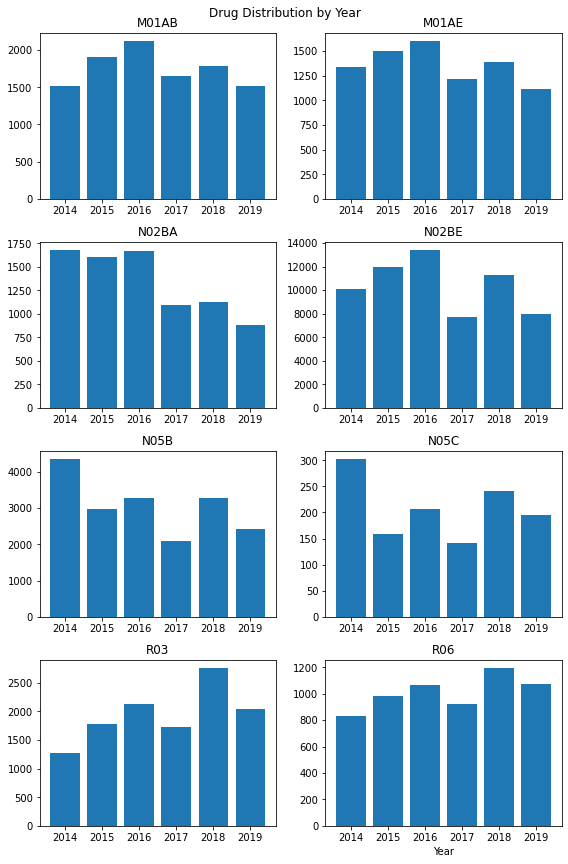

In [ ]:
#View drug sales by year

# Group drug sales by year
drug_list = df.columns.tolist()[1:9]
gb_year = df.groupby(by=['Year']).sum(numeric_only=True)

# Set plot variables
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(8, 12)

# Create plot
for i, drug in enumerate(drug_list):
    ax[int(np.floor(i/2))][i%2].bar(gb_year.index, gb_year[drug])
    ax[int(np.floor(i/2))][i%2].set_title(drug)

# Show plot
fig.tight_layout()
fig.suptitle('Drug Distribution by Year')
fig.subplots_adjust(top=0.95)
plt.xlabel('Year')
plt.show()

## Decompose observations

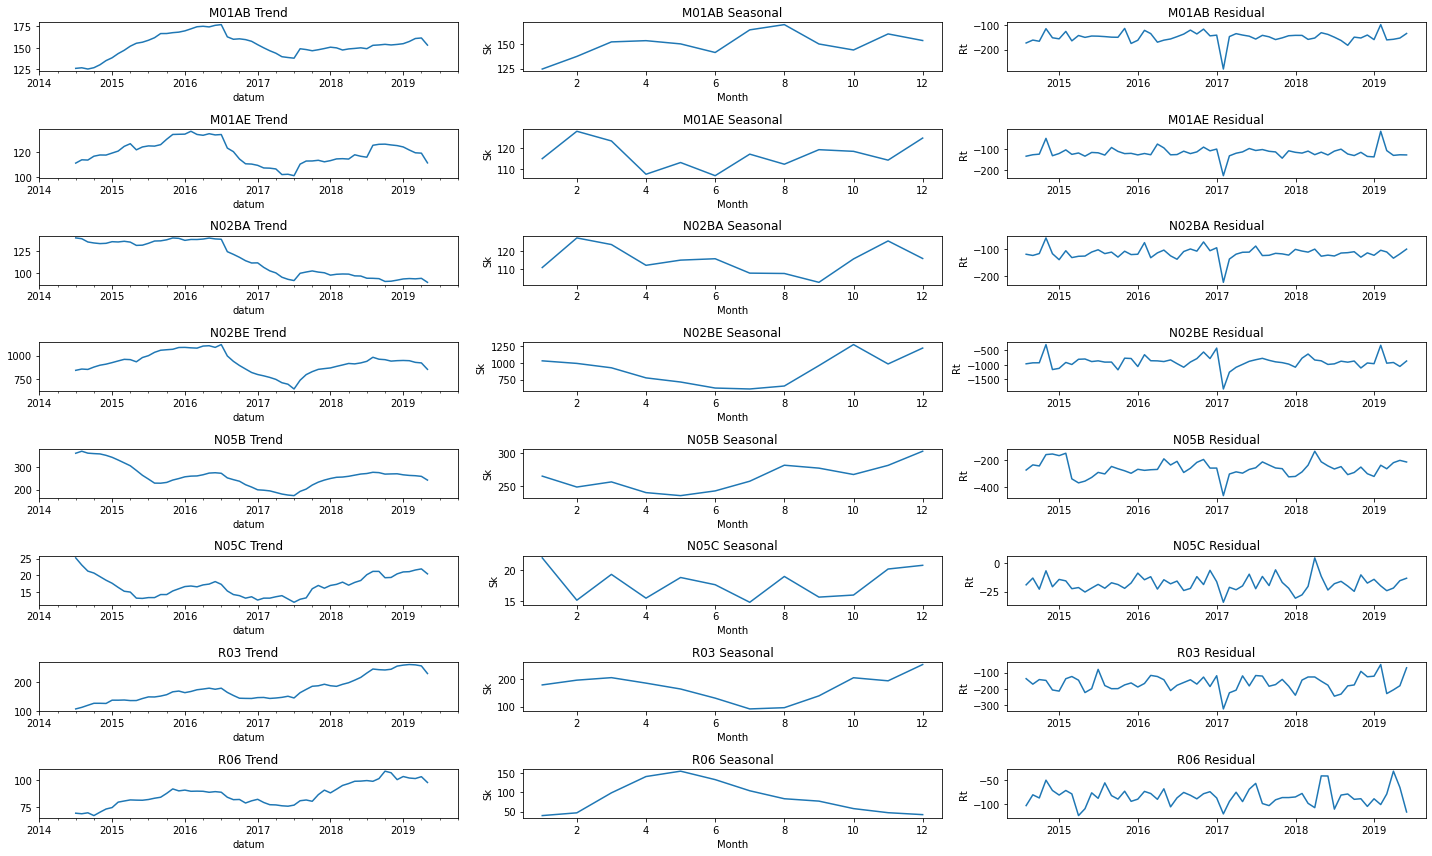

In [ ]:
fig = plt.figure(figsize=(20,12))
i=1

for col in drug_list:
  #Get drug's time series
  ts = df.set_index('datum')[col]
  
  #Plot the trend
  tlen = 12
  Tt = ts.rolling(window=tlen, center=True).mean()
  plt.subplot(8,3,i)
  Tt.plot()
  plt.title(f'{col} Trend')
  
  #Detrend the series
  yt = ts[tlen//2:(-tlen//2)+1] - Tt[tlen//2:(-tlen//2)+1]
  
  #Find Sk
  Sk = ts.groupby(ts.index.month).mean()

  #Plot sk
  i += 1
  plt.subplot(8,3,i)
  Sk.plot()
  plt.xlabel('Month')
  plt.ylabel('Sk')
  plt.title(f'{col} Seasonal')

  #Compute residuals
  new = yt.reset_index()
  new['Rt'] = new.apply(lambda row: row[col] - Sk[row['datum'].month], axis=1)
  Rt = new.set_index('datum')['Rt']

  #Plot
  i += 1
  plt.subplot(8,3,i)
  plt.plot(Rt)
  plt.ylabel('Rt')
  plt.title(f'{col} Residual')
  i += 1
plt.tight_layout()
plt.show()

## Try same thing but weekly

In [ ]:
dfw = pd.read_csv('salesweekly.csv.xls')
dfw['datum']= pd.to_datetime(dfw['datum'])
dfw["week_number"] = dfw["datum"].dt.week
dfw['Month'] = pd.DatetimeIndex(dfw['datum']).month
dfw['Year'] = pd.DatetimeIndex(dfw['datum']).year
display(dfw)

<ipython-input-19-90ec16eaacf9>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  dfw["week_number"] = dfw["datum"].dt.week


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,week_number,Month,Year
0,2014-01-05,14.00,11.670,21.30,185.950,41.0,0.0,32.000000,7.00,1,1,2014
1,2014-01-12,29.33,12.680,37.90,190.700,88.0,5.0,21.000000,7.20,2,1,2014
2,2014-01-19,30.67,26.340,45.90,218.400,80.0,8.0,29.000000,12.00,3,1,2014
3,2014-01-26,34.00,32.370,31.50,179.600,80.0,8.0,23.000000,10.00,4,1,2014
4,2014-02-02,31.02,23.350,20.70,159.880,84.0,12.0,29.000000,12.00,5,2,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
297,2019-09-15,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50,37,9,2019
298,2019-09-22,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00,38,9,2019
299,2019-09-29,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10,39,9,2019
300,2019-10-06,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13,40,10,2019


In [ ]:
#Check for empty strings 
empty = np.array([(dfw[col].astype(str).unique() == '').any() for col in dfw.columns.tolist()])
print("Any empty strings: " + str((empty == True).any()))

#Check for any missing data
print('\nAny missing data (by column):')
display(dfw.isnull().any())

Any empty strings: False

Any missing data (by column):


datum          False
M01AB          False
M01AE          False
N02BA          False
N02BE          False
N05B           False
N05C           False
R03            False
R06            False
week_number    False
Month          False
Year           False
dtype: bool

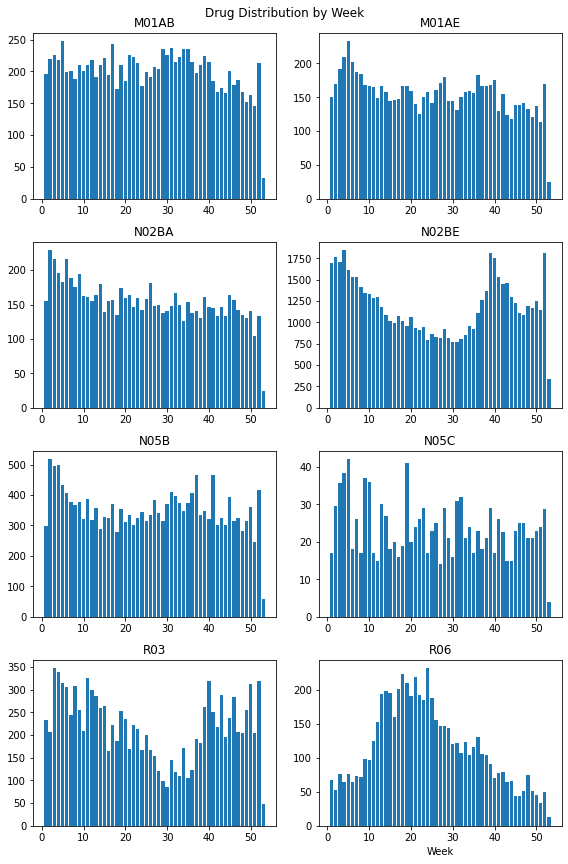

In [ ]:
#View drug sales by year

# Group drug sales by week
drug_list = dfw.columns.tolist()[1:9]
gb_year = dfw.groupby(by=['week_number']).sum(numeric_only=True)

# Set plot variables
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(8, 12)

# Create plot
for i, drug in enumerate(drug_list):
    ax[int(np.floor(i/2))][i%2].bar(gb_year.index, gb_year[drug])
    ax[int(np.floor(i/2))][i%2].set_title(drug)

# Show plot
fig.tight_layout()
fig.suptitle('Drug Distribution by Week')
fig.subplots_adjust(top=0.95)
plt.xlabel('Week')
plt.show()

<ipython-input-23-cc5c743be423>:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  Sk = ts.groupby(ts.index.week).mean()
<ipython-input-23-cc5c743be423>:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  Sk = ts.groupby(ts.index.week).mean()
<ipython-input-23-cc5c743be423>:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  Sk = ts.groupby(ts.in

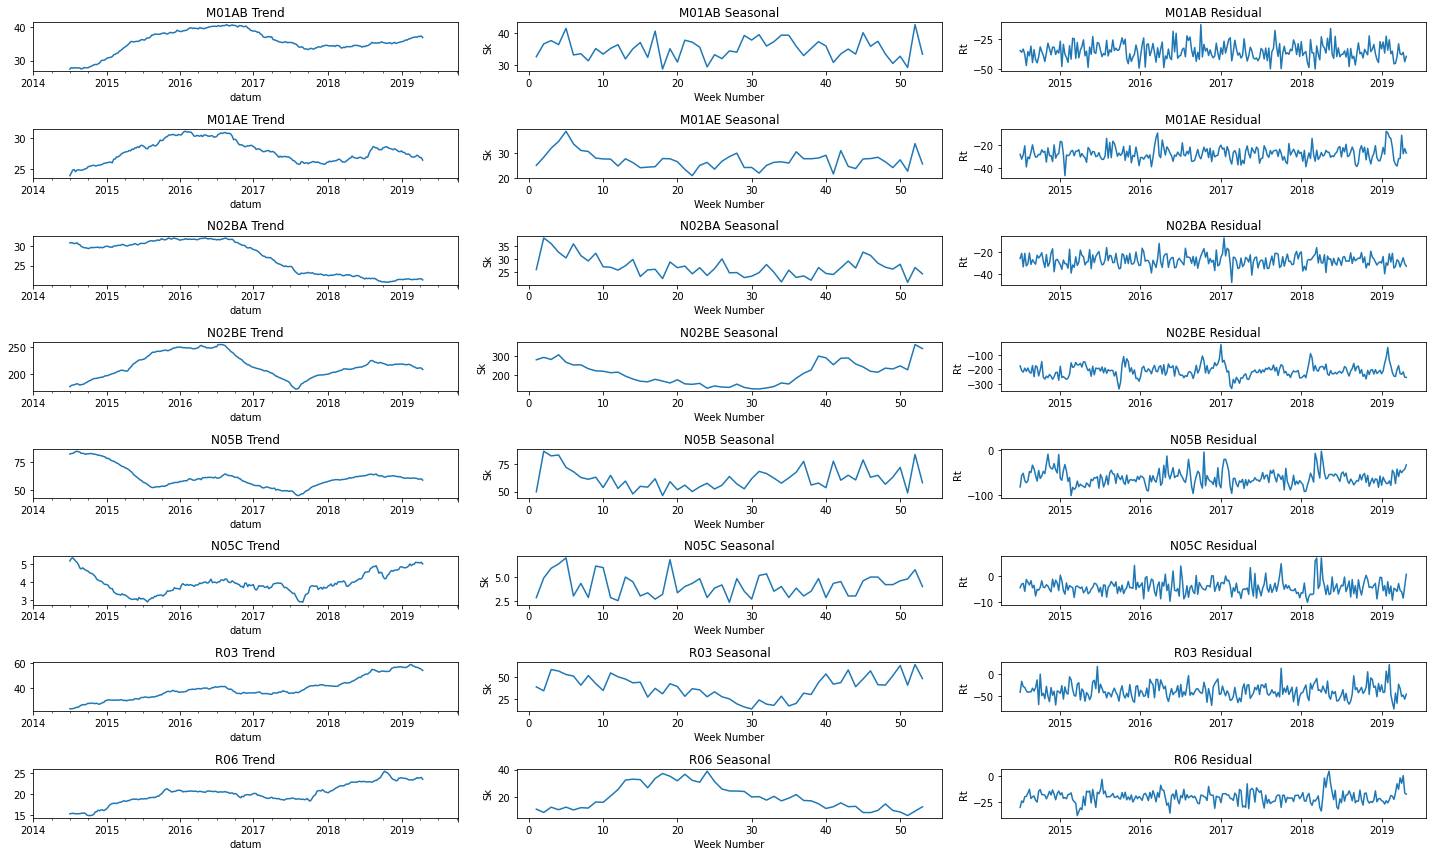

In [ ]:
fig = plt.figure(figsize=(20,12))
i=1

for col in drug_list:
  #Get drug's time series
  ts = dfw.set_index('datum')[col]
  
  #Plot the trend
  tlen = 52
  Tt = ts.rolling(window=tlen, center=True).mean()
  plt.subplot(8,3,i)
  Tt.plot()
  plt.title(f'{col} Trend')
  
  #Detrend the series
  yt = ts[tlen//2:(-tlen//2)+1] - Tt[tlen//2:(-tlen//2)+1]
  
  #Find Sk
  Sk = ts.groupby(ts.index.week).mean()

  #Plot sk
  i += 1
  plt.subplot(8,3,i)
  Sk.plot()
  plt.xlabel('Week Number')
  plt.ylabel('Sk')
  plt.title(f'{col} Seasonal')

  #Compute residuals
  new = yt.reset_index()
  new['Rt'] = new.apply(lambda row: row[col] - Sk[row['datum'].week], axis=1)
  Rt = new.set_index('datum')['Rt']
  if col == 'N02BA':
    rt_N02BA = Rt

  #Plot
  i += 1
  plt.subplot(8,3,i)
  plt.plot(Rt)
  plt.ylabel('Rt')
  plt.title(f'{col} Residual')
  i += 1
plt.tight_layout()
plt.show()

# Try for daily

In [ ]:
dfd = pd.read_csv('salesdaily.csv.xls')
dfd['datum']= pd.to_datetime(dfd['datum'])
dfd["day_number"] = pd.DatetimeIndex(dfd['datum']).day
dfd['Month'] = pd.DatetimeIndex(dfd['datum']).month
dfd['Year'] = pd.DatetimeIndex(dfd['datum']).year
display(dfd)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,day_number
0,2014-01-02,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,2014,1,248,Thursday,2
1,2014-01-03,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,2014,1,276,Friday,3
2,2014-01-04,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,2014,1,276,Saturday,4
3,2014-01-05,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,2014,1,276,Sunday,5
4,2014-01-06,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,2014,1,276,Monday,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2019-10-04,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday,4
2102,2019-10-05,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday,5
2103,2019-10-06,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday,6
2104,2019-10-07,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday,7


In [ ]:
#Check for empty strings 
empty = np.array([(dfd[col].astype(str).unique() == '').any() for col in dfd.columns.tolist()])
print("Any empty strings: " + str((empty == True).any()))

#Check for any missing data
print('\nAny missing data (by column):')
display(dfd.isnull().any())

Any empty strings: False

Any missing data (by column):


datum           False
M01AB           False
M01AE           False
N02BA           False
N02BE           False
N05B            False
N05C            False
R03             False
R06             False
Year            False
Month           False
Hour            False
Weekday Name    False
day_number      False
dtype: bool

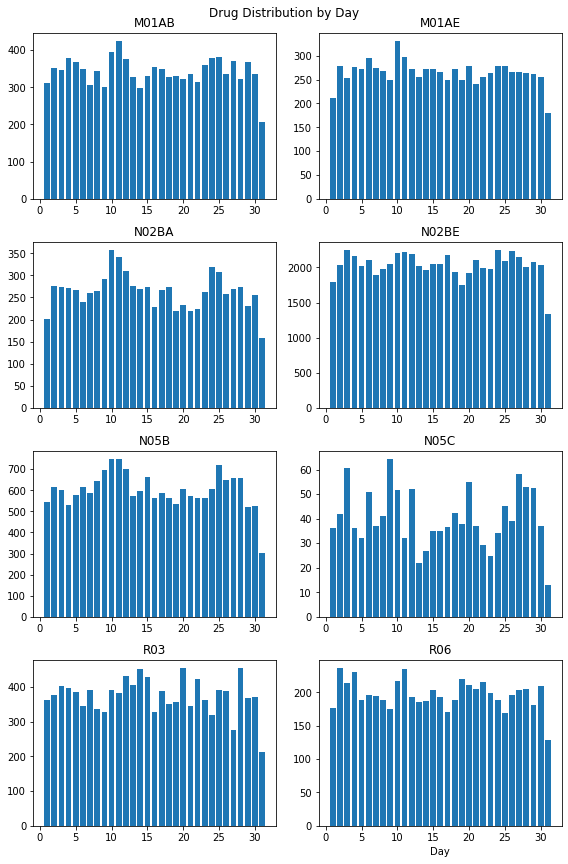

In [ ]:
#View drug sales by year

# Group drug sales by week
drug_list = dfd.columns.tolist()[1:9]
gb_year = dfd.groupby(by=['day_number']).sum(numeric_only=True)

# Set plot variables
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(8, 12)

# Create plot
for i, drug in enumerate(drug_list):
    ax[int(np.floor(i/2))][i%2].bar(gb_year.index, gb_year[drug])
    ax[int(np.floor(i/2))][i%2].set_title(drug)

# Show plot
fig.tight_layout()
fig.suptitle('Drug Distribution by Day')
fig.subplots_adjust(top=0.95)
plt.xlabel('Day')
plt.show()

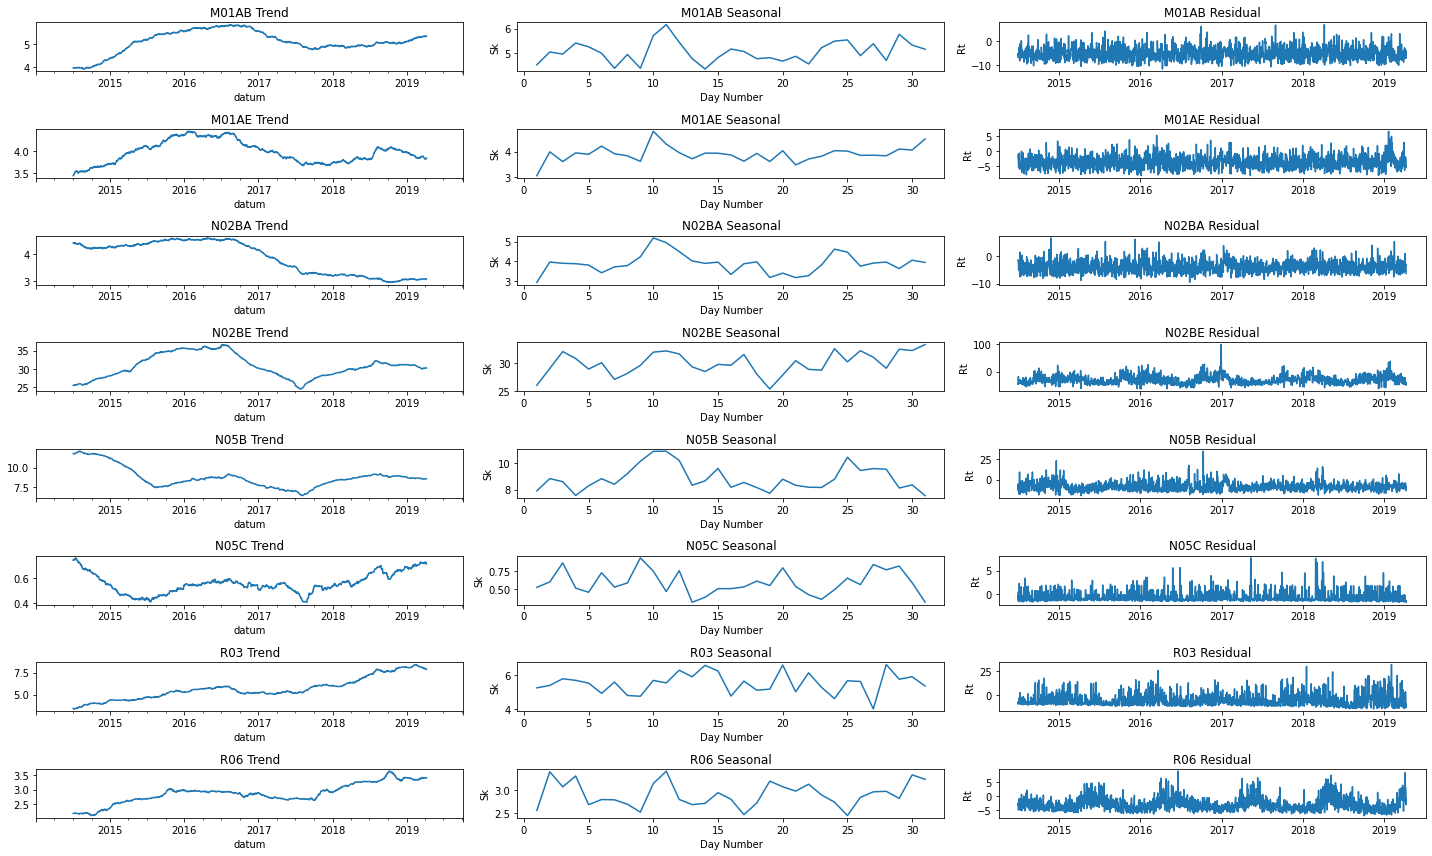

In [ ]:
fig = plt.figure(figsize=(20,12))
i=1

for col in drug_list:
  #Get drug's time series
  ts = dfd.set_index('datum')[col]
  
  #Plot the trend
  tlen = 365
  Tt = ts.rolling(window=tlen, center=True).mean()
  plt.subplot(8,3,i)
  Tt.plot()
  plt.title(f'{col} Trend')
  
  #Detrend the series
  yt = ts[tlen//2:(-tlen//2)+1] - Tt[tlen//2:(-tlen//2)+1]
  
  #Find Sk
  Sk = ts.groupby(ts.index.day).mean()

  #Plot sk
  i += 1
  plt.subplot(8,3,i)
  Sk.plot()
  plt.xlabel('Day Number')
  plt.ylabel('Sk')
  plt.title(f'{col} Seasonal')

  #Compute residuals
  new = yt.reset_index()
  new['Rt'] = new.apply(lambda row: row[col] - Sk[row['datum'].day], axis=1)
  Rt = new.set_index('datum')['Rt']
  if col == 'N02BA':
    rt_N02BA = Rt

  #Plot
  i += 1
  plt.subplot(8,3,i)
  plt.plot(Rt)
  plt.ylabel('Rt')
  plt.title(f'{col} Residual')
  i += 1
plt.tight_layout()
plt.show()

In [ ]:
#Get the weekly residuals
print(rt_N02BA)

# creating training, validation, and test datasets
train, valid = train_test_split(rt_N02BA, test_size=.1, shuffle=False)
valid, test = train_test_split(valid, test_size=.4, shuffle=False)
print(train)

datum
2014-07-03   -1.323318
2014-07-04   -1.304690
2014-07-05   -2.240145
2014-07-06   -4.839306
2014-07-07   -4.121201
                ...   
2019-04-05   -2.876264
2019-04-06   -3.497069
2019-04-07   -2.792115
2019-04-08   -3.563069
2019-04-09   -6.306610
Name: Rt, Length: 1742, dtype: float64
datum
2014-07-03   -1.323318
2014-07-04   -1.304690
2014-07-05   -2.240145
2014-07-06   -4.839306
2014-07-07   -4.121201
                ...   
2018-10-12   -6.457804
2018-10-13   -3.716564
2018-10-14   -0.639428
2018-10-15   -3.911164
2018-10-16   -4.284884
Name: Rt, Length: 1567, dtype: float64
